# HW 6

Miembros del grupo:
- 
- ÁLVARO CABRERIZO DE GARNICA
- JUAN SEVILLA FERNÁNDEZ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [2]:
df_train = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_train.parquet")
df_val = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_val.parquet")
df_oot = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_oot.parquet")

In [3]:
#drop indeterminates
df_train = df_train.loc[df_train.indeterm==False]
df_val = df_val.loc[df_val.indeterm==False]
df_oot = df_oot.loc[df_oot.indeterm==False]

In [4]:
#get the serialized data from previous session
import pickle
input_d2  = pickle.load(open("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/output_HW5.pkl", 'rb'))
corr_data, features = input_d2['corr_data'], input_d2['features']
df_iv, df_psi = input_d2['iv_df'], input_d2['psi_df']


## Filter out features

### Drop highly correlated features

In [5]:
corr_data

[('CreditScoreRangeLower',
  1,
  CreditScoreRangeUpper    1.0
  Name: CreditScoreRangeLower, dtype: float64),
 ('CreditScoreRangeUpper',
  1,
  CreditScoreRangeLower    1.0
  Name: CreditScoreRangeUpper, dtype: float64),
 ('CurrentCreditLines',
  2,
  OpenCreditLines          0.957426
  OpenRevolvingAccounts    0.853989
  Name: CurrentCreditLines, dtype: float64),
 ('OpenCreditLines',
  2,
  CurrentCreditLines       0.957426
  OpenRevolvingAccounts    0.888447
  Name: OpenCreditLines, dtype: float64),
 ('TotalCreditLinespast7years',
  1,
  TotalTrades    0.942083
  Name: TotalCreditLinespast7years, dtype: float64),
 ('OpenRevolvingAccounts',
  2,
  CurrentCreditLines    0.853989
  OpenCreditLines       0.888447
  Name: OpenRevolvingAccounts, dtype: float64),
 ('TotalTrades',
  1,
  TotalCreditLinespast7years    0.942083
  Name: TotalTrades, dtype: float64),
 ('TotalProsperPaymentsBilled',
  1,
  OnTimeProsperPayments    0.988512
  Name: TotalProsperPaymentsBilled, dtype: float64),
 ('

In [6]:
#run through the iv ranking, and drop features if they are correlated with any feature with better ranking
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr_data, feats_sorted)

Drop: TotalProsperPaymentsBilled
Drop: CreditScoreRangeUpper
Drop: OpenCreditLines
Drop: OpenRevolvingAccounts
Drop: TotalCreditLinespast7years


In [7]:
len(features), len(features_keep), len(corr_data)

(45, 40, 9)

### Drop features with low IV

In [8]:
# IV filtering with this treshold
df_iv.head()

,feature,IV
29,IncomeRange,0.145180
31,StatedMonthlyIncome,0.119612
34,OnTimeProsperPayments,0.113475
28,DebtToIncomeRatio,0.111675
39,ScorexChangeAtTimeOfListing,0.108946


**TODO 1** Implementa una función que devuelva solo las columnas que tengan un IV inferior a un umbral dado. Usa el dataframe df_iv.

In [9]:
def lowIVFeatures(df_iv, th=0.02):
    """Returns a list with the features that have an IV lower that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    # IMPLEMENT YOUR CODE HERE
    df_iv.loc[df_iv["IV"]<0.02]
    
    return df_iv.loc[df_iv["IV"]<th]["feature"]

In [10]:
# capture low IV features
low_iv_feats = lowIVFeatures(df_iv)
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(45, 40, 23)

### Drop unstable features

In [61]:
# PSI filtering with this treshold
df_psi.head()

,feature,PSI
42,Recommendations,0.000000e+00
21,PublicRecordsLast12Months,5.352324e-09
41,PercentFunded,2.141008e-08
20,PublicRecordsLast10Years,2.724033e-05
18,AmountDelinquent,7.428038e-05


**TODO 2** Implementa una función que devuelva solo las columnas que tengan un PSI mayor a un umbral dado. Usa el dataframe df_psi.

In [12]:
def highPSIFeatures(df_psi, TH_PSI=0.25):
    """Returns a list with the features that have a PSI higher that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    # IMPLEMENT YOUR CODE HERE
    
    df_psi.loc[df_psi["PSI"]>0.25]
    
    return df_psi.loc[df_psi["PSI"]>TH_PSI]["feature"]

In [13]:
# capture high (unstable) features
high_psi_features = highPSIFeatures(df_psi)
features_keep_psi = list(set(features_keep_iv) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_iv), len(features_keep_psi)

(45, 40, 23, 21)

In [14]:
final_features = features_keep_psi
final_features

['TradesOpenedLast6Months',
 'DebtToIncomeRatio',
 'CurrentCreditLines',
 'OnTimeProsperPayments',
 'ProsperPaymentsOneMonthPlusLate',
 'TotalTrades',
 'IncomeRange',
 'TotalProsperLoans',
 'IsBorrowerHomeowner',
 'IncomeVerifiable',
 'ProsperPrincipalBorrowed',
 'CurrentlyInGroup',
 'CreditScoreRangeLower',
 'BorrowerState',
 'Occupation',
 'ProsperPrincipalOutstanding',
 'ScorexChangeAtTimeOfListing',
 'AmountDelinquent',
 'StatedMonthlyIncome',
 'ProsperPaymentsLessThanOneMonthLate',
 'InquiriesLast6Months']

## Preprocessing - Set up bucketing - "Trameado"

#### For numerical features

In [15]:
# features

In [16]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    # dividimos entre 100
    perc_sliders = [v/100. for v in input_slider]
    # calculamos los límites de la variable
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

#### For categorical features

In [17]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

In [18]:
#example of numerical bucketing
cuts_num = get_bucket_numfeature(df_train, 'CreditScoreRangeLower', 6)
dumm_num = apply_bucketing_num(df_train, 'CreditScoreRangeLower', cuts_num)
dumm_num[:10]

,CreditScoreRangeLower_640|680,CreditScoreRangeLower_680|700,CreditScoreRangeLower_700|720,CreditScoreRangeLower_720|760,CreditScoreRangeLower_760|880
0,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
5,0,0,0,0,1
6,0,0,0,0,0
7,0,0,1,0,0
8,0,0,0,1,0
9,0,0,0,0,1
10,0,0,0,0,0


In [19]:
#example of categorical bucketing
cuts_cat = get_bucket_catfeature(df_train, 'Occupation', 6)
dumm_cat = apply_bucketing_cat(df_train, 'Occupation', cuts_cat)
dumm_cat[:10]

,Occupation_Analyst,Occupation_Computer Programmer,Occupation_Executive,Occupation_Other,Occupation_Professional
0,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0
10,0,0,0,1,0


### Set up bucketing, then apply it

In [20]:
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes in (object, bool):
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        print(feature)
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [21]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

TradesOpenedLast6Months
DebtToIncomeRatio
CurrentCreditLines
OnTimeProsperPayments
ProsperPaymentsOneMonthPlusLate
TotalTrades
IncomeRange
TotalProsperLoans
IsBorrowerHomeowner
IncomeVerifiable
ProsperPrincipalBorrowed
CurrentlyInGroup
CreditScoreRangeLower
BorrowerState
Occupation
ProsperPrincipalOutstanding
ScorexChangeAtTimeOfListing
AmountDelinquent
StatedMonthlyIncome
ProsperPaymentsLessThanOneMonthLate
InquiriesLast6Months


{'TradesOpenedLast6Months': [0.0, 1.0, 20.0],
 'DebtToIncomeRatio': [0.0, 0.13, 0.19, 0.29, 10.01],
 'CurrentCreditLines': [0.0, 6.0, 9.0, 12.0, 38.0],
 'OnTimeProsperPayments': [0.0, 10.0, 19.0, 34.0, 103.0],
 'ProsperPaymentsOneMonthPlusLate': [0.0, 21.0],
 'TotalTrades': [1.0, 14.0, 21.0, 30.0, 110.0],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'TotalProsperLoans': [0.0, 1.0, 2.0, 7.0],
 'IsBorrowerHomeowner': [True, False],
 'IncomeVerifiable': [True, False],
 'ProsperPrincipalBorrowed': [0.0, 3000.0, 5000.0, 9000.0, 57499.0],
 'CurrentlyInGroup': [False, True],
 'CreditScoreRangeLower': [600.0, 660.0, 700.0, 740.0, 880.0],
 'BorrowerState': ['CA', 'FL', 'NY', 'TX'],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive'],
 'ProsperPrincipalOutstanding': [0.0, 817.575, 3049.0924999999997, 21523.79],
 'ScorexChangeAtTimeOfListing': [-209.0, -32.0, -3.0, 30.0, 257.0],
 'AmountDelinquent': [0.0, 249209.0],
 'StatedM

In [22]:
len(final_features), len(dict_bucketing.keys())

(21, 21)

In [23]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes in (object, bool):
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [24]:
apply_bucketing(df_train, 'CreditScoreRangeLower', dict_bucketing['CreditScoreRangeLower']).head()

,CreditScoreRangeLower_660|700,CreditScoreRangeLower_700|740,CreditScoreRangeLower_740|880
0,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
5,0,0,1


In [25]:
# Apply the bucketing

# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_val_preproc = pd.concat(list_df_val, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [26]:
df_tr_preproc.shape, df_oot_preproc.shape

((15259, 56), (13220, 58))

In [27]:
# Capture the target in each subset
y_tr, y_val, y_oot = df_train['bad'], df_val['bad'], df_oot['bad']

## Modeling

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [29]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [30]:
#check buckets correlations
corr = df_tr_preproc[keep_cols_buck].corr()
orig_features = keep_cols_buck.values.tolist()
corr_TH = 0.75
n_corr_list=[]
corr_feats_list=[]
for f in orig_features:
    #get correlation entries for the feature
    corr_f = corr[f][[col for col in orig_features if col!=f]]
    #work with absolute value
    corr_f_abs = corr_f.abs()
    #get features above corr TH
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)

corr_buckets = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, orig_features) if n>0]
corr_buckets

[('DebtToIncomeRatio_NA',
  1,
  IncomeVerifiable_True    0.999027
  Name: DebtToIncomeRatio_NA, dtype: float64),
 ('OnTimeProsperPayments_NA',
  6,
  ProsperPaymentsOneMonthPlusLate_NA        1.000000
  TotalProsperLoans_NA                      1.000000
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ScorexChangeAtTimeOfListing_NA            0.996584
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  Name: OnTimeProsperPayments_NA, dtype: float64),
 ('ProsperPaymentsOneMonthPlusLate_NA',
  6,
  OnTimeProsperPayments_NA                  1.000000
  TotalProsperLoans_NA                      1.000000
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ScorexChangeAtTimeOfListing_NA            0.996584
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  Name: ProsperPaymentsOneMonthPlusLate_NA, dtype: float64),
 ('TotalProsperLoans_NA',
  6,
  OnTimeProsperPayments_NA 

In [31]:
glm_cols = get_uncorr_feats(corr_buckets, orig_features)

Drop: ProsperPaymentsOneMonthPlusLate_NA
Drop: TotalProsperLoans_NA
Drop: IncomeVerifiable_True
Drop: ProsperPrincipalBorrowed_NA
Drop: ProsperPrincipalOutstanding_NA
Drop: ScorexChangeAtTimeOfListing_NA
Drop: ProsperPaymentsLessThanOneMonthLate_NA


In [32]:
glm_cols

['TradesOpenedLast6Months_1|20',
 'DebtToIncomeRatio_0.1|0.2',
 'DebtToIncomeRatio_0.2|0.3',
 'DebtToIncomeRatio_0.3|10',
 'DebtToIncomeRatio_NA',
 'CurrentCreditLines_6|9',
 'CurrentCreditLines_9|12',
 'CurrentCreditLines_12|38',
 'OnTimeProsperPayments_10|19',
 'OnTimeProsperPayments_19|34',
 'OnTimeProsperPayments_34|103',
 'OnTimeProsperPayments_NA',
 'ProsperPaymentsOneMonthPlusLate_10|21',
 'TotalTrades_14|21',
 'TotalTrades_21|30',
 'TotalTrades_30|110',
 'IncomeRange_$25,000-49,999',
 'IncomeRange_$50,000-74,999',
 'IncomeRange_$75,000-99,999',
 'IncomeRange_Other',
 'TotalProsperLoans_1|2',
 'TotalProsperLoans_2|7',
 'IsBorrowerHomeowner_True',
 'ProsperPrincipalBorrowed_3000|5000',
 'ProsperPrincipalBorrowed_5000|9000',
 'ProsperPrincipalBorrowed_9000|57499',
 'CurrentlyInGroup_True',
 'CreditScoreRangeLower_660|700',
 'CreditScoreRangeLower_700|740',
 'CreditScoreRangeLower_740|880',
 'BorrowerState_FL',
 'BorrowerState_NY',
 'BorrowerState_Other',
 'BorrowerState_TX',
 'Occ

In [33]:
#train first model
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc[glm_cols], y_tr)

LogisticRegression(C=0.01)

In [34]:
df_tr_preproc[glm_cols].head()

,TradesOpenedLast6Months_1|20,DebtToIncomeRatio_0.1|0.2,DebtToIncomeRatio_0.2|0.3,DebtToIncomeRatio_0.3|10,DebtToIncomeRatio_NA,CurrentCreditLines_6|9,CurrentCreditLines_9|12,CurrentCreditLines_12|38,OnTimeProsperPayments_10|19,OnTimeProsperPayments_19|34,...,ScorexChangeAtTimeOfListing_-32|-3,ScorexChangeAtTimeOfListing_-3|30,ScorexChangeAtTimeOfListing_30|257,AmountDelinquent_124604|249209,StatedMonthlyIncome_3167|4667,StatedMonthlyIncome_4667|6833,StatedMonthlyIncome_6833|483333,ProsperPaymentsLessThanOneMonthLate_14|28,InquiriesLast6Months_1|2,InquiriesLast6Months_2|27
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [35]:
# Predict for all subsets
pred_log1_tr = lr.predict_proba(df_tr_preproc[glm_cols])[:, 1]
pred_log1_val = lr.predict_proba(df_val_preproc[glm_cols])[:, 1]
pred_log1_oot = lr.predict_proba(df_oot_preproc[glm_cols])[:, 1]

In [36]:
Log1_aucs = get_auc(y_tr, pred_log1_tr), get_auc(y_val, pred_log1_val), get_auc(y_oot, pred_log1_oot)
Log1_aucs

(0.7179479819865071, 0.6992407997681831, 0.6901786470733411)

In [37]:
# Get p-values
# Mostly from: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

import scipy.stats as stat
def get_p_vals(lr, X):
    denom = (2.0*(1.0+np.cosh(lr.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = lr.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values#        
    return p_values

def show_lr_summary(p_values, features, lr):
    df_ret = pd.DataFrame({'feature': features,
                           'p_val': p_values,
                           'betas': lr.coef_.tolist()[0]})[['feature', 'betas', 'p_val']]
    return df_ret

In [38]:
# If there was any issue with the data (high correlations...)
# This would be messy, with NAs, or maybe not even able to run
p_values = get_p_vals(lr, df_tr_preproc[glm_cols])
show_lr_summary(p_values, glm_cols, lr)

,feature,betas,p_val
0,TradesOpenedLast6Months_1|20,0.279671,0.000875
1,DebtToIncomeRatio_0.1|0.2,-0.189019,0.078805
2,DebtToIncomeRatio_0.2|0.3,0.047985,0.650278
3,DebtToIncomeRatio_0.3|10,0.253394,0.024095
4,DebtToIncomeRatio_NA,0.349738,0.002146
5,CurrentCreditLines_6|9,-0.127333,0.163463
6,CurrentCreditLines_9|12,-0.192076,0.086509
7,CurrentCreditLines_12|38,-0.098583,0.404284
8,OnTimeProsperPayments_10|19,-0.215896,0.225780
9,OnTimeProsperPayments_19|34,-0.137774,0.461083


#### P-value based feature selection

In [39]:
# remove each bucket with the highest p-value N times
# assess how the AUC changes
N_iterations = len(glm_cols) - 3
glm_cols_pvals = [c for c in glm_cols]

# keep the AUCs in each interation 
auc_train, auc_val, auc_oot = [], [], []
# List of tuples where all selected features status will 
# be stored per iteration
features_it_pval = []

# for each iteration
for it in range(N_iterations):
    #capture the feature to be dropped
    #in the first iteration we are using the p_values from the model trained 'outside'
    feat_drop = [feat for feat, p in zip(glm_cols_pvals, p_values) if p == max(p_values)][0]
    glm_cols_pvals.remove(feat_drop)
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_pvals], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_pvals])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_pvals])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_pvals])[:, 1]
    #get aucs
    auc_train.append(get_auc(y_tr, pred_tr))
    auc_val.append(get_auc(y_val, pred_val)) 
    auc_oot.append(get_auc(y_oot, pred_oot))
    #get p-values
    p_values = get_p_vals(lr_it, df_tr_preproc[glm_cols_pvals])
    #keep features status at iteration
    features_it_pval.append((it, [c for c in glm_cols_pvals]))

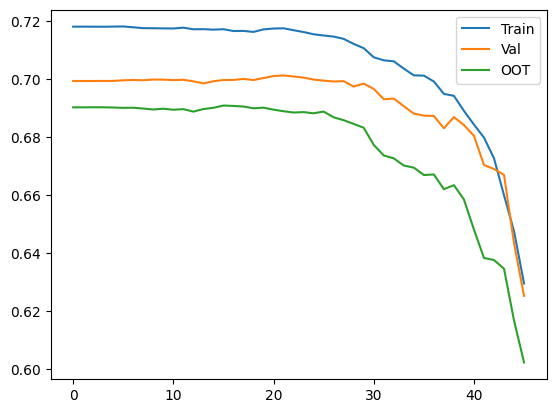

In [40]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [41]:
# At iteration 40 more or less it stays stable
final_features_bucketing = [feats for it, feats in features_it_pval if it==26][0]
# Train the final model with the interesting buckets
lr_final = LogisticRegression(solver='lbfgs', C=0.01)
lr_final.fit(df_tr_preproc[final_features_bucketing], y_tr)

LogisticRegression(C=0.01)

In [42]:
# Predict for all subsets
pred_tr = lr_final.predict_proba(df_tr_preproc[final_features_bucketing])[:, 1]
pred_val = lr_final.predict_proba(df_val_preproc[final_features_bucketing])[:, 1]
pred_oot = lr_final.predict_proba(df_oot_preproc[final_features_bucketing])[:, 1]

Log2_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

In [43]:
p_values = get_p_vals(lr_final, df_tr_preproc[final_features_bucketing])
show_lr_summary(p_values, final_features_bucketing, lr_final)

,feature,betas,p_val
0,TradesOpenedLast6Months_1|20,0.277750,0.000865
1,DebtToIncomeRatio_0.1|0.2,-0.199809,0.032869
2,DebtToIncomeRatio_0.3|10,0.239762,0.007339
3,DebtToIncomeRatio_NA,0.352955,0.000371
4,CurrentCreditLines_6|9,-0.134440,0.114667
5,CurrentCreditLines_9|12,-0.211180,0.034110
6,CurrentCreditLines_12|38,-0.127372,0.185924
7,OnTimeProsperPayments_10|19,-0.217252,0.183019
8,OnTimeProsperPayments_19|34,-0.148270,0.361752
9,OnTimeProsperPayments_34|103,-0.208240,0.201186


#### AUC based feature selection

In [44]:
# Try to remove all available features.
# Remove the feature that has the lowest impact in AUC
N_iterations = len(glm_cols) - 3
glm_cols_auc = [c for c in glm_cols]

auc_train, auc_val, auc_oot = [], [], []
features_it_auc = []
for it in range(N_iterations):
    print('Working for iteration: {}'.format(str(it)))
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_auc], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_auc])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_auc])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_auc])[:, 1]
    #get base aucs
    auc_train_it, auc_val_it, auc_oot_it = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)
    auc_train.append(auc_train_it)
    auc_val.append(auc_val_it) 
    auc_oot.append(auc_oot_it)
    #set up minimum gap
    min_gap = 500
    for feat_eval in glm_cols_auc:
        #use validation AUC only as evaluation metric
        #keep features in iteration it, but the feature under evaluation
        glm_cols_auc_ev = [c for c in glm_cols_auc if c!=feat_eval]
        lr_it_ev = LogisticRegression(solver='lbfgs', C=0.01)
        lr_it_ev.fit(df_tr_preproc[glm_cols_auc_ev], y_tr)
        #predit @ val data
        pred_val = lr_it_ev.predict_proba(df_val_preproc[glm_cols_auc_ev])[:, 1]
        #get auc @ val
        auc_val_it_ev = get_auc(y_val, pred_val)
        #check gap
        gap_val_auc = auc_val_it - auc_val_it_ev
        #capture the feature that has the lowest AUC impact
        if gap_val_auc < min_gap:
            candidate_drop = feat_eval
            min_gap = gap_val_auc
    #remove from the feature set the selected feature
    glm_cols_auc.remove(candidate_drop)
    #keep features status at iteration
    features_it_auc.append((it, [c for c in glm_cols_auc]))

Working for iteration: 0
Working for iteration: 1
Working for iteration: 2
Working for iteration: 3
Working for iteration: 4
Working for iteration: 5
Working for iteration: 6
Working for iteration: 7
Working for iteration: 8
Working for iteration: 9
Working for iteration: 10
Working for iteration: 11
Working for iteration: 12
Working for iteration: 13
Working for iteration: 14
Working for iteration: 15
Working for iteration: 16
Working for iteration: 17
Working for iteration: 18
Working for iteration: 19
Working for iteration: 20
Working for iteration: 21
Working for iteration: 22
Working for iteration: 23
Working for iteration: 24
Working for iteration: 25
Working for iteration: 26
Working for iteration: 27
Working for iteration: 28
Working for iteration: 29
Working for iteration: 30
Working for iteration: 31
Working for iteration: 32
Working for iteration: 33
Working for iteration: 34
Working for iteration: 35
Working for iteration: 36
Working for iteration: 37
Working for iteration:

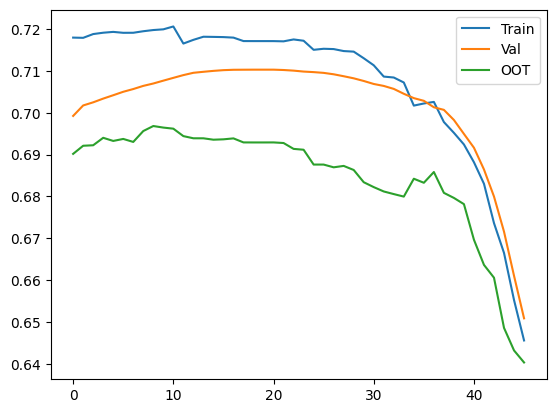

In [45]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [46]:
# get the iteration where it stays stable
final_features_bucketing_auc = [feats for it, feats in features_it_auc if it==26][0]
# Train the final model with the interesting buckets
lr_final_auc = LogisticRegression(solver='lbfgs', C=0.01)
lr_final_auc.fit(df_tr_preproc[final_features_bucketing_auc], y_tr)

LogisticRegression(C=0.01)

In [47]:
# Predict for all subsets
pred_tr = lr_final_auc.predict_proba(df_tr_preproc[final_features_bucketing_auc])[:, 1]
pred_val = lr_final_auc.predict_proba(df_val_preproc[final_features_bucketing_auc])[:, 1]
pred_oot = lr_final_auc.predict_proba(df_oot_preproc[final_features_bucketing_auc])[:, 1]

Log3_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

#### Gain Table

**TODO3** Implementa una función que te calcule una gain table, con una fila for bucket de scores, y con las siguientes columnas:
 - avg_pred: El score medio en ese bucket
 - BR: La tasa de malos en ese bucket
 - N_bads: El número de malos en ese bucket
 - N: El número de muestras en ese bucket
 - N_goods: El número de buenos en ese bucket
 - pct_bad_acum: El porcentaje de malos acumulados en ese bucket
 - pct_approv_acum: El porcentae de aprobación hasta ese bucket
 
La tabla estará ordenada de scores más bajos (mejor perfil), a scores más altos (peor perfil)

In [48]:
# Tabla de eficiencia / Gain table
def get_gain_table(pred, df, col_target='bad', n_buckets=10):
    """Generate the gain table given a population, and its predictions
    
    Args:
        pred: np.array / pd.Series containing predictions
        df: Pandas DataFrame containing the population to be assesed
        col_target: Name of the target column
        n_buckets: Number of buckets for the gain table
        
    Returns:
        Pandas DataFrame representing the gain table
    """
    df['pred'] = pred
    pred_cuts = df['pred'].quantile(np.linspace(0, 1, num = n_buckets + 1))
    df['pred_cut'] = pd.cut(df['pred'], bins = pred_cuts)
    df_group = df.groupby(df["pred_cut"]).agg(
    avg_pred=pd.NamedAgg(column="pred", aggfunc="mean"),
    BR=pd.NamedAgg(column="bad", aggfunc="mean"),
    N_bads=pd.NamedAgg(column="bad", aggfunc="sum"),
    N=pd.NamedAgg(column="pred", aggfunc="count"))
    
    df_group["N_goods"] = df_group["N"] - df_group["N_bads"]
    df_group["pct_bad_acum"] = (df_group["N_bads"].cumsum()/len(df))*100
    df_group["pct_approv_acum"] = (df_group["N_goods"].cumsum()/len(df))*100 

    return df_group

# Use the pd.cut() function


In [49]:
# usa la función get_gain_table en el conjunto oot
get_gain_table(pred_oot, df_oot)

,avg_pred,BR,N_bads,N,N_goods,pct_bad_acum,pct_approv_acum
pred_cut,,,,,,,
"(0.0148, 0.0396]",0.033261,0.012869,17,1321,1304,0.128593,9.863843
"(0.0396, 0.0475]",0.043683,0.023845,32,1342,1310,0.370651,19.773071
"(0.0475, 0.0534]",0.050729,0.034456,45,1306,1261,0.711044,29.311649
"(0.0534, 0.0609]",0.057150,0.036009,48,1333,1285,1.074130,39.031770
"(0.0609, 0.0668]",0.063523,0.044697,59,1320,1261,1.520424,48.570348
"(0.0668, 0.074]",0.070240,0.052710,71,1347,1276,2.057489,58.222390
"(0.074, 0.0815]",0.077424,0.059094,77,1303,1226,2.639939,67.496218
"(0.0815, 0.0898]",0.085109,0.090426,119,1316,1197,3.540091,76.550681
"(0.0898, 0.104]",0.095973,0.091603,120,1310,1190,4.447806,85.552194


**TODO 4** Comenta la gain table anterior (sobre el conjunto OOT). ¿Qué conclusiones podemos sacar con respecto al funcionamiento del modelo? 

Introduce tu comentario aquí. 
no hay un descenso de bads cuando desciende el bucket. Al contrario de goods.
el numero es constanste para cada bucket


In [50]:
# gain table for training sample
get_gain_table(pred_tr, df_train)

,avg_pred,BR,N_bads,N,N_goods,pct_bad_acum,pct_approv_acum
pred_cut,,,,,,,
"(0.0145, 0.0377]",0.031246,0.005902,9,1525,1516,0.058982,9.935120
"(0.0377, 0.0453]",0.041828,0.019595,30,1531,1501,0.255587,19.771938
"(0.0453, 0.0523]",0.049209,0.030460,47,1543,1496,0.563602,29.575988
"(0.0523, 0.0591]",0.055747,0.030585,46,1504,1458,0.865063,39.131005
"(0.0591, 0.0658]",0.062384,0.058785,90,1531,1441,1.454879,48.574612
"(0.0658, 0.0736]",0.069483,0.069737,106,1520,1414,2.149551,57.841274
"(0.0736, 0.0817]",0.077056,0.079292,121,1526,1405,2.942526,67.048955
"(0.0817, 0.0903]",0.084992,0.104644,160,1529,1369,3.991087,76.020709
"(0.0903, 0.106]",0.098123,0.125641,196,1560,1364,5.275575,84.959696


### Random Forest

In [63]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df_train[final_features].dtypes
cat_features = df_train[final_features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in final_features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [64]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [67]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

**TODO 5** Entrena un RandomForestClassifier, y evalua su rendimiento (AUC, gain table). Revisa la documentación del modelo, y elige parámetros razonables

In [68]:
# forest = RandomForestClassifier(criterion='gini',
   #n_estimators=5,
    #random_state=1,
    #n_jobs=2)
#
# Fit the model
#
#forest.fit(X_train, y_train)
 
#
# Measure model performance
#
#y_pred = forest.predict(X_test)
#print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [75]:
df_tr_preproc_rf[keep_cols_rf].columns

Index(['TradesOpenedLast6Months', 'DebtToIncomeRatio', 'CurrentCreditLines',
       'OnTimeProsperPayments', 'ProsperPaymentsOneMonthPlusLate',
       'TotalTrades', 'TotalProsperLoans', 'ProsperPrincipalBorrowed',
       'CreditScoreRangeLower', 'ProsperPrincipalOutstanding',
       'ScorexChangeAtTimeOfListing', 'AmountDelinquent',
       'StatedMonthlyIncome', 'ProsperPaymentsLessThanOneMonthLate',
       'InquiriesLast6Months', 'IncomeRange_$25,000-49,999',
       'IncomeRange_$50,000-74,999', 'IncomeRange_$75,000-99,999',
       'IncomeRange_Other', 'IsBorrowerHomeowner_True',
       'IncomeVerifiable_True', 'CurrentlyInGroup_True', 'BorrowerState_FL',
       'BorrowerState_NY', 'BorrowerState_Other', 'BorrowerState_TX',
       'Occupation_Executive', 'Occupation_Other', 'Occupation_Professional'],
      dtype='object')

In [76]:
len(df_tr_preproc_rf)

15259

In [77]:
len(df_train)

15259

In [78]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

X_tr = df_tr_preproc_rf[keep_cols_rf]
X_val = df_val_preproc_rf[keep_cols_rf]
X_oot = df_oot_preproc_rf[keep_cols_rf]

# Train your model
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=5,
                            random_state=1,
                            n_jobs=-1)



# rf is the RandomForestClassifier object you will work with
rf.fit(X_tr,df_train["bad"])

# # Predict for all subsets
# pred_rf_tr = #
# pred_rf_val = # 
# pred_rf_oot = #

# # Get AUC metrics in all subsets
                       
# # Compute the gain table for the OOT set
# rf_aucs = ...

RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=1)

In [ ]:
# Show Feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': rf.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

**TODO 6** Entrena un XGBClassifier, y evalua su rendimiento (AUC, gain table). Revisa la documentación del modelo y elige parámetros razonables https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier

### XGBoost

In [80]:
# Train a XGBClassifier
from xgboost import XGBClassifier

# Train your model
xgb = # xgb is the RandomForestClassifier object you will work with

# Predict for all subsets
pred_xgb_tr = #
pred_xgb_val = # 
pred_xgb_oot = #
# Get AUC metrics in all subsets
                       
                          
# Compute the gain table for the OOT set
xgb_aucs = # ...

SyntaxError: invalid syntax (3553146315.py, line 5)

In [81]:
# Sow feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': xgb.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

NameError: name 'keep_cols_rf' is not defined

## Compare model performances

In [ ]:
df_aucs = pd.DataFrame([Log1_aucs, Log2_aucs, Log3_aucs, rf_aucs, xgb_aucs])
df_aucs.columns = ["AUC_Train", "AUC_Val", "AUC_OOT"]
df_aucs.index = ["Logistic", "Log_Pval", "Log_AUC", "RF", "XGBoost"]
df_aucs

**TODO 7** Comenta el rendimiento de los modelos. ¿Qué modelo moverias a producción? 